<a href="https://colab.research.google.com/github/Olimaol/notebooks-deeprl/blob/main/solutions-output/11-Pytorch.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pytorch tutorial

The goal of this tutorial is to very quickly present pytorch, the main deep learning framework nowadays. 

We will train a small fully-connected network on MNIST and observe what happens when the inputs or outputs are correlated, by training successively on the 0 digits, then the 1s, etc. This will explain why correlated inputs are a problem for neural networks.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Installing Pytorch

Pytorch provides a lot of ready-made layer types, activation functions, optimizers and so on. Do not hesitate to read its documentation on <https://pytorch.org/docs/stable/index.html>.

The first step is to install pytorch if you are not on colab (where it is installed by default). The easiest way is to use pip:
    
```bash
pip install torch torchvision
```

`torchvision` is necessary if you want to deal with images, such as the MNIST dataset.

`torch` is now available for importing. There is quite a lot to import, so let's just copy and paste:


In [2]:
# Imports
import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Subset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split

# Select hardware: 
if torch.cuda.is_available(): # GPU
    device = torch.device("cuda")
elif torch.backends.mps.is_available(): # Metal (Macos)
    device = torch.device("mps")
else: # CPU
    device = torch.device("cpu")
print(f"Device: {device}")

Device: cpu


## Random data

Let's train a MLP on some dummy data. To show the (overfitting) power of deep neural networks, we will try to learn noise by heart. The following cell creates 1000 random samples of dimension 10, artificially ordered in 3 classes:

In [3]:
N = 1000
nb_features = 10
nb_classes = 3

X = np.random.uniform(-1.0, 1.0, (N, nb_features))
t = np.random.randint(0, nb_classes, (N, ))

Let's start by splitting this data in training / validation sets using scikit-learn.

In [4]:
X_train, X_test, t_train, t_test = train_test_split(X, t, test_size=0.1)

The four numpy arrays have to be converted to torch tensors. The inputs are `float32` (32 bits) numbers, while the classes are integers (`long`).

In [5]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
t_train_tensor = torch.tensor(t_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
t_test_tensor = torch.tensor(t_test, dtype=torch.long)

Using these four tensors, we can now create datasets (`TensorDataset`) and data loaders (`DataLoader`) allowing to sample minibatches very easily. Note that you have to define the batch size at the time of creation of the data loaders. It cannot be changed later unless you create new ones.

In [6]:
# Create TensorDatasets for both train and test sets
train_dataset = TensorDataset(X_train_tensor, t_train_tensor)
test_dataset = TensorDataset(X_test_tensor, t_test_tensor)

# Create DataLoaders for train and test sets
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Now is time to create an MLP in pytorch. The standard way of creating a neural network is to create a class inheriting from `torch.nn.module`. 

There are only two methods that need to be defined:

1. The constructor `__init__(self, ...)` that instantiates the layers. Do not forget the first line with `super()`, it is super important. The first argument `MLP` should be replaced with the name of the class if you change it. The layers are created in the constructor and saved as attributes to the class (e.g. `self.fc1`). The order does not matter.
2. The forward method `forward(self, x)`that defines how the input `x` will be processed, and in which order the layers will be called.

The following class defines an MLP with two hidden layers, and the ReLU activation function:

In [7]:
class MLP(torch.nn.Module):
    "MLP with two hidden layers."

    def __init__(self, nb_features, nb_layer1, nb_layer2, nb_classes):
        super(MLP, self).__init__() # Obligatory, do not forget

        # Layers
        self.fc1 = torch.nn.Linear(nb_features, nb_layer1)
        self.fc2 = torch.nn.Linear(nb_layer1, nb_layer2)
        self.output = torch.nn.Linear(nb_layer2, nb_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.output(x)
        return x

`torch.nn.Linear(N, M)` creates a fully-connected layer between a layer of size `N` and a layer of size `M`.

The input tensor is passed as the argument `x` in `def forward(self, x)`.

There is more than one way to create this network. For example, the ReLU non-linearity does not have to come from the functional module `F`, but could be a layer of its own:

```python
class MLP(torch.nn.Module):
    "MLP with two hidden layers."

    def __init__(self, nb_features, nb_layer1, nb_layer2, nb_classes):
        super(MLP, self).__init__() # Obligatory, do not forget

        # Layers
        self.fc1 = torch.nn.Linear(nb_features, nb_layer1)
        self.fc2 = torch.nn.Linear(nb_layer1, nb_layer2)
        self.output = torch.nn.Linear(nb_layer2, nb_classes)

        # Activations
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.output(x)
        return x
```

Another option would be the `Sequential` model, which would be much closer to `keras` and much shorter to use, but for some reasons (reusability, etc) it is not recommended:

```python
model = torch.nn.Sequential(
    torch.nn.Linear(nb_features, nb_layer1),  
    torch.nn.ReLU(), 
    torch.nn.Linear(nb_layer1, nb_layer2),  
    torch.nn.ReLU(), 
    torch.nn.Linear(nb_layer2, nb_classes)
)
```

Note that the output layer does not use a softmax activation function, although we are doing a classification. The cross-entropy loss function that we will define later expects logits as an input, not probabilities, so we just keep the numbers as they are.

Next we will define the training procedure.

> For users with keras experience: The equivalent of a high-level keras API (like using `model.fit()`) would be **pytorch lightning** (<https://lightning.ai/>) or **pytorch ignite** (<https://pytorch.org/ignite>)

We will define a `train()` method applying backpropagation and the optimizer on each minibatch. Skipping some details, the pseudo-algorithm would be something like this:

```python
# Create the neural network
model = MLP(nb_features, nb_layer1, nb_layer2, nb_classes)

# Select the optimizer, e.g. Adam
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Select the loss function, here cross-entropy as we do a classification
loss_function = torch.nn.CrossEntropyLoss()

# Iterate over the minibatches contained in the loader
for batch_idx, (data, target) in enumerate(train_loader):

    # Reinitialize the gradients (important!)
    optimizer.zero_grad()

    # Forward pass
    output = model(data)

    # Compute the loss function on the minibatch
    loss = loss_function(output, target)

    # Backpropagate the gradients
    loss.backward()
    
    # Apply the optimizer on the gradients
    optimizer.step()
```

Note, that although you could use the `model.forward(data)` method, it is recommended to use `model(data)`, which will call the `forward()` method internally, but will also take care of some other things.

We also need to send the data to the GPU if needed, compute the metrics (loss and accuracy), etc. The following function is quite generic and can be reused in many networks:

In [8]:
def train(model, device, train_loader, optimizer, loss_function):
    
    # Tell pytorch to start training, i.e. to remember gradients, enable dropout, etc.
    model.train()

    # Initialize metrics
    training_loss = 0
    correct = 0 ; total = 0
    
    # Iterate over the minibatches
    for batch_idx, (data, target) in enumerate(train_loader):
    
        # Send the data to the device
        data, target = data.to(device), target.to(device)
    
        # Reinitialize the gradients
        optimizer.zero_grad()
    
        # Make the forward pass
        output = model(data)
    
        # Compute the loss function on the minibatch
        loss = loss_function(output, target)

        # Accumulate training loss. data.size(0) is the batch size.
        training_loss += loss.item() * data.size(0)
    
        # Backpropagate the gradients
        loss.backward()
    
        # Apply the optimizer on the gradients
        optimizer.step()
    
        # Compute metrics
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        total += target.size(0)
        correct += pred.eq(target.view_as(pred)).sum().item()
    
    # Info
    training_loss /= len(train_loader.dataset)
    accuracy = 100 * correct / total
    print(f'Training loss {training_loss:.4f}, accuracy {accuracy:.4f}')

    return training_loss, accuracy


The following function does a similar function on the validation set, but does NOT apply backpropagation. `model.eval()` and `with torch.no_grad():` make sure that the gradients are not computed, speeding up the computations (also dropout and batchnorm are switched off).

In [9]:
def validate(model, device, test_loader, loss_function):

    # Evaluation mode, without the gradients
    model.eval()

    # Initialize metrics
    test_loss = 0
    correct = 0; total = 0

    # Important! No backpropagation when testing.
    with torch.no_grad():

        # Iterate over the minibatches
        for data, target in test_loader:

            # Send the data to the device
            data, target = data.to(device), target.to(device)

            # Make the forward pass
            output = model(data)

            # Compute the loss function on the minibatch
            test_loss += loss_function(output, target).item() * data.size(0)

            # Compute metrics
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            total += target.size(0)
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    # Info
    test_loss /= len(test_loader.dataset)
    accuracy = 100 * correct / total
    print(f'Validation loss: {test_loss:.4f}, accuracy: {accuracy:.4f}')

    return test_loss, accuracy

Now we can create the neural network (with two hidden layers of 100 neurons each), the Adam optimizer with a fixed learning rate and the cross-entropy loss. Note again that `torch.nn.CrossEntropyLoss()` expects the network to output logits, not probabilities.

It is important to **send** the network to the device (GPU, TPU, etc) after creating an instance of the class.

In [10]:
# Create the model
model = MLP(nb_features, 100, 100, nb_classes).to(device)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Loss function
loss_function = torch.nn.CrossEntropyLoss()

**Q:** Train the model for 50 epochs, by calling repeatedly the `train()` and `validate()` methods. Record and plot the training/validation losses and accuracies, and plot them. Comment on the final accuracies on the training and test sets, and what this means in terms of overfitting.

In [11]:
# Solution:
# Recording arrays
train_losses = [] ; train_accs = []
val_losses = [] ; val_accs = []

# 50 epochs of training and validation
for epoch in range(50):

    print(f"Epoch: {epoch+1}")

    # Train 
    train_loss, train_acc = train(model, device, train_loader, optimizer, loss_function)

    # Validation
    val_loss, val_acc = validate(model, device, test_loader, loss_function)

    print('-'*30)

    train_losses.append(train_loss); train_accs.append(train_acc)
    val_losses.append(val_loss); val_accs.append(val_acc)

Epoch: 1
Training loss 1.1116, accuracy 34.2222
Validation loss: 1.1196, accuracy: 26.0000
------------------------------
Epoch: 2
Training loss 1.0848, accuracy 38.8889
Validation loss: 1.1313, accuracy: 36.0000
------------------------------
Epoch: 3
Training loss 1.0845, accuracy 39.8889
Validation loss: 1.1241, accuracy: 33.0000
------------------------------
Epoch: 4
Training loss 1.0686, accuracy 43.3333
Validation loss: 1.1586, accuracy: 28.0000
------------------------------
Epoch: 5
Training loss 1.0609, accuracy 43.5556
Validation loss: 1.1792, accuracy: 31.0000
------------------------------
Epoch: 6


Training loss 1.0523, accuracy 42.8889
Validation loss: 1.1665, accuracy: 31.0000
------------------------------
Epoch: 7


Training loss 1.0342, accuracy 44.3333
Validation loss: 1.1730, accuracy: 32.0000
------------------------------
Epoch: 8
Training loss 1.0127, accuracy 47.5556
Validation loss: 1.2520, accuracy: 31.0000
------------------------------
Epoch: 9
Training loss 0.9930, accuracy 50.6667
Validation loss: 1.2313, accuracy: 25.0000
------------------------------
Epoch: 10
Training loss 0.9625, accuracy 52.7778
Validation loss: 1.3299, accuracy: 30.0000
------------------------------
Epoch: 11
Training loss 0.9379, accuracy 54.0000
Validation loss: 1.2611, accuracy: 33.0000
------------------------------
Epoch: 12
Training loss 0.9088, accuracy 55.3333
Validation loss: 1.3450, accuracy: 29.0000
------------------------------
Epoch: 13


Training loss 0.8675, accuracy 58.0000
Validation loss: 1.4220, accuracy: 32.0000
------------------------------
Epoch: 14


Training loss 0.8195, accuracy 60.8889
Validation loss: 1.5023, accuracy: 31.0000
------------------------------
Epoch: 15
Training loss 0.7862, accuracy 64.2222
Validation loss: 1.4227, accuracy: 41.0000
------------------------------
Epoch: 16
Training loss 0.7472, accuracy 66.0000
Validation loss: 1.4825, accuracy: 39.0000
------------------------------
Epoch: 17
Training loss 0.6957, accuracy 69.2222
Validation loss: 1.5725, accuracy: 36.0000
------------------------------
Epoch: 18
Training loss 0.6981, accuracy 69.5556
Validation loss: 1.5146, accuracy: 39.0000
------------------------------
Epoch: 19
Training loss 0.6254, accuracy 72.8889
Validation loss: 1.7552, accuracy: 34.0000
------------------------------
Epoch: 20


Training loss 0.6149, accuracy 73.0000
Validation loss: 1.7267, accuracy: 30.0000
------------------------------
Epoch: 21


Training loss 0.5881, accuracy 73.6667
Validation loss: 1.8046, accuracy: 33.0000
------------------------------
Epoch: 22
Training loss 0.5287, accuracy 76.5556
Validation loss: 1.9590, accuracy: 32.0000
------------------------------
Epoch: 23
Training loss 0.4754, accuracy 81.7778
Validation loss: 2.0980, accuracy: 29.0000
------------------------------
Epoch: 24
Training loss 0.4582, accuracy 81.5556
Validation loss: 2.3314, accuracy: 40.0000
------------------------------
Epoch: 25
Training loss 0.4759, accuracy 81.6667
Validation loss: 2.0104, accuracy: 40.0000
------------------------------
Epoch: 26
Training loss 0.3819, accuracy 84.4444
Validation loss: 2.1156, accuracy: 42.0000
------------------------------
Epoch: 27


Training loss 0.3563, accuracy 86.2222
Validation loss: 2.5989, accuracy: 34.0000
------------------------------
Epoch: 28


Training loss 0.3055, accuracy 89.2222
Validation loss: 2.6296, accuracy: 35.0000
------------------------------
Epoch: 29
Training loss 0.2975, accuracy 89.2222
Validation loss: 2.6473, accuracy: 36.0000
------------------------------
Epoch: 30
Training loss 0.4247, accuracy 84.0000
Validation loss: 2.8965, accuracy: 35.0000
------------------------------
Epoch: 31
Training loss 0.3521, accuracy 85.0000
Validation loss: 2.7836, accuracy: 35.0000
------------------------------
Epoch: 32
Training loss 0.2752, accuracy 90.0000
Validation loss: 2.9442, accuracy: 37.0000
------------------------------
Epoch: 33
Training loss 0.3296, accuracy 88.5556
Validation loss: 3.2433, accuracy: 35.0000
------------------------------
Epoch: 34


Training loss 0.2426, accuracy 91.2222
Validation loss: 3.2580, accuracy: 32.0000
------------------------------
Epoch: 35


Training loss 0.1930, accuracy 94.5556
Validation loss: 3.3145, accuracy: 31.0000
------------------------------
Epoch: 36
Training loss 0.1514, accuracy 95.5556
Validation loss: 3.4742, accuracy: 36.0000
------------------------------
Epoch: 37
Training loss 0.1243, accuracy 97.0000
Validation loss: 3.5031, accuracy: 32.0000
------------------------------
Epoch: 38
Training loss 0.1122, accuracy 97.1111
Validation loss: 3.6925, accuracy: 35.0000
------------------------------
Epoch: 39
Training loss 0.1021, accuracy 97.2222
Validation loss: 3.7371, accuracy: 37.0000
------------------------------
Epoch: 40
Training loss 0.0779, accuracy 98.5556
Validation loss: 3.9163, accuracy: 32.0000
------------------------------
Epoch: 41


Training loss 0.0609, accuracy 99.1111
Validation loss: 3.9740, accuracy: 35.0000
------------------------------
Epoch: 42


Training loss 0.0550, accuracy 99.0000
Validation loss: 4.0796, accuracy: 32.0000
------------------------------
Epoch: 43
Training loss 0.0539, accuracy 98.8889
Validation loss: 4.4446, accuracy: 32.0000
------------------------------
Epoch: 44
Training loss 0.0437, accuracy 99.6667
Validation loss: 4.5057, accuracy: 32.0000
------------------------------
Epoch: 45
Training loss 0.0359, accuracy 99.6667
Validation loss: 4.4405, accuracy: 34.0000
------------------------------
Epoch: 46
Training loss 0.0354, accuracy 99.5556
Validation loss: 4.5699, accuracy: 34.0000
------------------------------
Epoch: 47
Training loss 0.0274, accuracy 99.6667
Validation loss: 4.6724, accuracy: 34.0000
------------------------------
Epoch: 48


Training loss 0.0253, accuracy 99.6667
Validation loss: 4.7078, accuracy: 34.0000
------------------------------
Epoch: 49


Training loss 0.0219, accuracy 99.7778
Validation loss: 4.8641, accuracy: 35.0000
------------------------------
Epoch: 50
Training loss 0.0178, accuracy 99.8889
Validation loss: 4.9561, accuracy: 35.0000
------------------------------


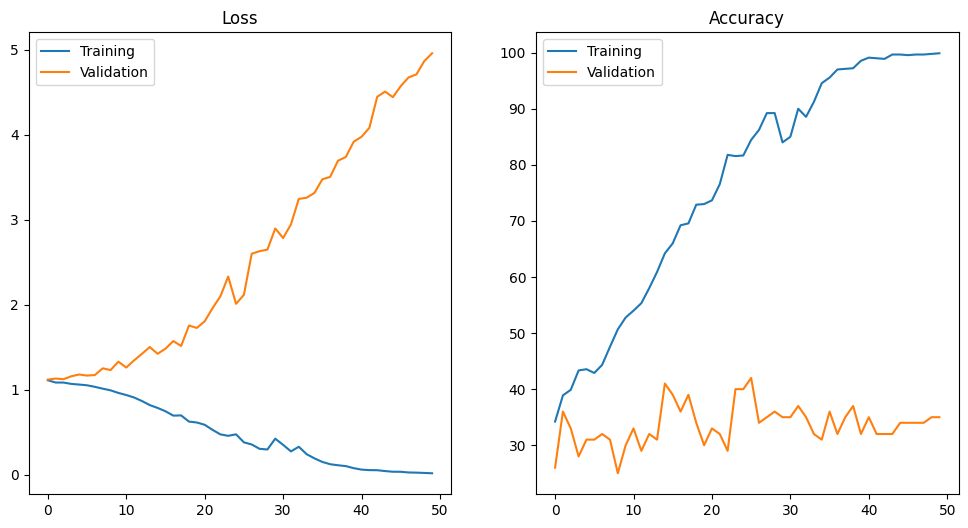

In [12]:
# Solution:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(train_losses, label='Training')
plt.plot(val_losses, label="Validation")
plt.title("Loss")
plt.legend()
plt.subplot(122)
plt.plot(train_accs, label='Training')
plt.plot(val_accs, label="Validation")
plt.title("Accuracy")
plt.legend()

**A:** The final training accuracy is 100%, the validation accuracy is 33%, i.e. chance level. The network has learned the training examples by heart, although they are totally random, but totally fails to generalize.

The main reason is that we have only 1000 training examples, with a total number of free parameters (VC dimension) around 11500. By definition, the model can learn this training set perfectly, although it is totally random. Its VC dimension is however way too high to generalize anything. It is even worse here: as the data is random, there is nothing to generalize. A nice example to demonstrate that NN overfit...

## Training a CNN on MNIST

Let's now try to learn something a bit more serious, the MNIST dataset. The following cell load the MNIST data (training set 60000 of 28x28x1 monochrome images, test set of 10000 images), and normalizes it (values betwen 0 and 1 for each pixel).

In [13]:
# torchvision.transform allows to normalize the images. The mean=0.1307 and std=0.3081 are common practice.
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert the image to a tensor (scaling to [0, 1])
    transforms.Normalize((0.1307,), (0.3081,))  # Normalize with mean and std
])

# Download the data if needed.
dataset_train = datasets.MNIST('./data', train=True, download=True, transform=transform)
dataset_test = datasets.MNIST('./data', train=False, download=True, transform=transform)

# Create the data loaders 
batch_size=128
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size)

  0%|          | 0.00/9.91M [00:00<?, ?B/s]

  8%|▊         | 786k/9.91M [00:00<00:01, 7.56MB/s]

100%|██████████| 9.91M/9.91M [00:00<00:00, 53.1MB/s]

  0%|          | 0.00/28.9k [00:00<?, ?B/s]

100%|██████████| 28.9k/28.9k [00:00<00:00, 1.47MB/s]

  0%|          | 0.00/1.65M [00:00<?, ?B/s]

 44%|████▎     | 721k/1.65M [00:00<00:00, 7.18MB/s]

100%|██████████| 1.65M/1.65M [00:00<00:00, 13.6MB/s]

  0%|          | 0.00/4.54k [00:00<?, ?B/s]

100%|██████████| 4.54k/4.54k [00:00<00:00, 11.1MB/s]

**Q:** Create a convolutional neural network with two convolutional layers (AlexNet-like) that can reach around 99% validation accuracy after **10 epochs**. Feel free to translate what you did in the course Neurocomputing, search the web, ask ChatGPT, etc. Some ingredients/tips you might need:

* Convolutional layers, obviously: <https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html>. You need to define the number of channels / features in the previous layer and in the next one. The first convolutional layer works on the image directly, so the number of input channels is 1 on MNIST (because the MNIST images are monochrome, it would be 3 for RGB images). Keep the kernel size at 3 (i.e. 3x3 filters) and define the padding as `'same'` or `'valid'`, as you prefer.

```python
self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding='same')
```

* Max-pooling layers can be defined using the functional module `F`:

```python
def forward(self, x):
    x = F.relu(self.conv1(x)) # Conv layer + ReLU
    x = F.max_pool2d(x, 2)  # 2x2 max pooling
```

or as a reusable layer:

```python
def __init__(self):
    self.max_pooling = torch.nn.MaxPool2d(2)
def forward(self, x):
    x = F.relu(self.conv1(x)) # Conv layer + ReLU
    x = self.max_pooling(x)  # 2x2 max pooling
```

The functional approach is usually preferred, but they are equivalent, pick the approach you prefer.

* After the last convolutional block, you need to **flatten** the tensor into a vector, before feeding it to the next fully-connected layer. It must be defined as a layer: 

```python
def __init__(self):
    self.flatten = torch.nn.Flatten()
def forward(self, x):
    x = self.flatten(x)  # flatten
```

* The caveat is the size of that flattened vector, which will be the first argument of the next FC layer. For convolutional layers, the (width, height) dimensions of the input image do not matter, but FC layers require fixed numbers of inputs. The size of the vector will depend on 1) the image size, 2) the number of conv and pooling layers, 3) the padding method, etc. 

The trick to find the size of that layer is to create the network up until the flatten layer, pass a single image to the network and print the shape of the returned tensor:

```python
class CNN(torch.nn.Module):
    def forward(self, x):
        ...
        x = self.flatten(x)
        return x

model = CNN().to(device)

# Random image (batch_size, channels, width, height)
img = torch.randn(1, 1, 28, 28).to(device)

# Forward pass
res = model(img)
print(res.shape)
```

For an AlexNet-like network on MNIST with 2 convolutional layers, `padding=same` and 32 features in the last convolutional layer, you should get `torch.Size([1, 1568])` or `torch.Size([1, 32, 7, 7])` depending on whether you print before or after `flatten()`. This means that you have one tensor (the first dimension is always the batch size) of size 7x7 with 32 features, or 1568 elements when flattened. This is the input size for the next FC layer. Of course, you have to adapt this to your network.

* You will likely observe overfitting if you only have conv, pooling and fc layers in your network. It never hurts to use a bit of dropout after each conv and fc layer. If you use the same level of dropout everywhere, you can define a single layer in `__init__` and use it in forward:

```python
def __init__(self):
    self.dropout = torch.nn.Dropout(p=0.5)
def forward(self, x):
    x = self.dropout(x)
```

If you want different dropout levels, create as many layers as needed, or use the functional `F.dropout(x, 0.5)`.

In [14]:
# Solution:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # First convolutional layer
        self.conv1 = torch.nn.Conv2d(1, 16, kernel_size=3, padding='same')
        # Second convolutional layer
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=3, padding='same')
        # Flatten layer
        self.flatten = torch.nn.Flatten()
        # Fully connected layer
        self.fc1 = torch.nn.Linear(32 * 7 * 7, 128)
        # Fully connected layer
        self.fc2 = torch.nn.Linear(128, 10)

        # Dropout layer
        self.dropout = torch.nn.Dropout(p=0.5)

    def forward(self, x):
        # Apply first convolution, followed by ReLU and max-pooling
        x = F.relu(self.conv1(x))
        x = self.dropout(x)
        x = F.max_pool2d(x, 2)  # 2x2 max pooling
        # Apply second convolution, followed by ReLU and max-pooling
        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        x = F.max_pool2d(x, 2)  # 2x2 max pooling
        # Flatten the tensor into a vector
        x = self.flatten(x)
        # Apply first fully connected layer, followed by ReLU
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        # Apply second fully connected layer (output layer)
        x = self.fc2(x)
        return x

In [15]:
# Solution:
model = CNN().to(device)

# Random image (batch_size, channels, width, height)
img = torch.randn(1, 1, 28, 28).to(device)

# Forward pass
res = model(img)
print(res.shape)

torch.Size([1, 10])


Epoch: 1


Training loss 0.3342, accuracy 89.6033


Validation loss: 0.1605, accuracy: 97.6800
------------------------------
Epoch: 2


Training loss 0.1299, accuracy 96.0817


Validation loss: 0.1178, accuracy: 98.4300
------------------------------
Epoch: 3


Training loss 0.1079, accuracy 96.8133


Validation loss: 0.0886, accuracy: 98.2400
------------------------------
Epoch: 4


Training loss 0.0912, accuracy 97.2717


Validation loss: 0.0728, accuracy: 98.8100
------------------------------
Epoch: 5


Training loss 0.0855, accuracy 97.3983


Validation loss: 0.0646, accuracy: 98.8100
------------------------------
Epoch: 6


Training loss 0.0794, accuracy 97.5933


Validation loss: 0.0634, accuracy: 98.8100
------------------------------
Epoch: 7


Training loss 0.0744, accuracy 97.6883


Validation loss: 0.0569, accuracy: 98.8800
------------------------------
Epoch: 8


Training loss 0.0695, accuracy 97.8633


Validation loss: 0.0476, accuracy: 98.9400
------------------------------
Epoch: 9


Training loss 0.0680, accuracy 97.9383


Validation loss: 0.0512, accuracy: 99.0500
------------------------------
Epoch: 10


Training loss 0.0647, accuracy 98.0267


Validation loss: 0.0438, accuracy: 98.9400
------------------------------


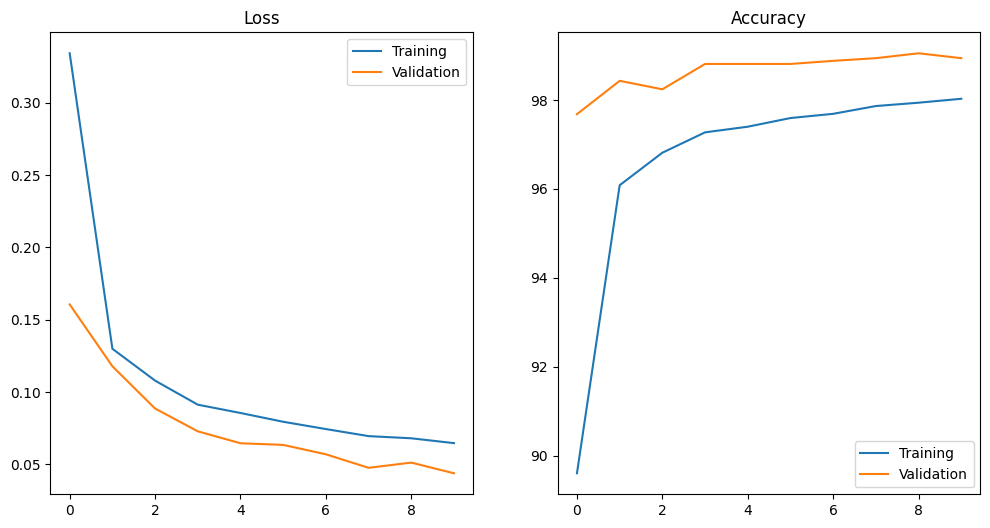

In [16]:
# Solution:
model = CNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_function = torch.nn.CrossEntropyLoss()

# Record
train_losses = [] ; train_accs = []
val_losses = [] ; val_accs = []

# 10 epochs of training and validation
for epoch in range(10):

    print(f"Epoch: {epoch+1}")

    # Train 
    train_loss, train_acc = train(model, device, train_loader, optimizer, loss_function)

    # Validation
    val_loss, val_acc = validate(model, device, test_loader, loss_function)

    print('-'*30)

    train_losses.append(train_loss); train_accs.append(train_acc)
    val_losses.append(val_loss); val_accs.append(val_acc)

# Plot training and validation metrics
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(train_losses, label='Training')
plt.plot(val_losses, label="Validation")
plt.title("Loss")
plt.legend()
plt.subplot(122)
plt.plot(train_accs, label='Training')
plt.plot(val_accs, label="Validation")
plt.title("Accuracy")
plt.legend()

## Correlated inputs

Now that we have a basic CNN working on MNIST, let's investigate why deep NN hate sequentially correlated inputs (which is the main justification for the experience replay memory in DQN). Is that really true, or is just some mathematical assumption that does not matter in practice?

The idea of this section is the following: we will train the same network as before for 10 epochs, but each epoch will train the network on all the zeros first, then all the ones, etc. Each epoch will contain the same number of training examples as before, but the order of presentation will be different (correlated instead of i.i.d).

To do so, we only need to sort the datasets according to their targets, and tell the Pytorch DataLoaders not to shuffle the data when sampling minibatches. 

The following function sorts the datasets `dataset_train` and `dataset_test` (generated earlier when downloading MNIST), so that the data loaders can iterative deterministically over them (the flag `shuffle=False` is important).

In [17]:
# Function to sort dataset by labels
def sort_dataset_by_labels(dataset):
    sorted_indices = np.argsort(dataset.targets.numpy())
    sorted_dataset = Subset(dataset, sorted_indices)
    return sorted_dataset

# Load and sort the MNIST dataset
train_loader_sorted = DataLoader(
    sort_dataset_by_labels(dataset_train), 
    batch_size=batch_size, shuffle=False
)
test_loader_sorted = DataLoader(
    sort_dataset_by_labels(dataset_test), 
    batch_size=batch_size, shuffle=False
)


**Q:** Using these new data loaders, train the same CNN as before (after reinitializing it, of course) for 10 epochs. What do you observe? Why?

Epoch: 1


Training loss 2.0385, accuracy 33.2267


Validation loss: 2.2795, accuracy: 10.5000
------------------------------
Epoch: 2


Training loss 1.7048, accuracy 42.0400


Validation loss: 2.4083, accuracy: 10.0900
------------------------------
Epoch: 3


Training loss 0.8020, accuracy 75.2367


Validation loss: 2.1916, accuracy: 18.0400
------------------------------
Epoch: 4


Training loss 0.4484, accuracy 86.3650


Validation loss: 1.9203, accuracy: 34.7900
------------------------------
Epoch: 5


Training loss 0.3149, accuracy 90.3017


Validation loss: 1.7904, accuracy: 41.7200
------------------------------
Epoch: 6


Training loss 0.2825, accuracy 91.2817


Validation loss: 1.8030, accuracy: 39.2300
------------------------------
Epoch: 7


Training loss 0.2536, accuracy 92.1933


Validation loss: 1.7617, accuracy: 41.6200
------------------------------
Epoch: 8


Training loss 0.2276, accuracy 93.0583


Validation loss: 1.5107, accuracy: 49.5800
------------------------------
Epoch: 9


Training loss 0.2205, accuracy 93.3300


Validation loss: 1.4106, accuracy: 52.7400
------------------------------
Epoch: 10


Training loss 0.2158, accuracy 93.5567


Validation loss: 1.3372, accuracy: 54.4100
------------------------------


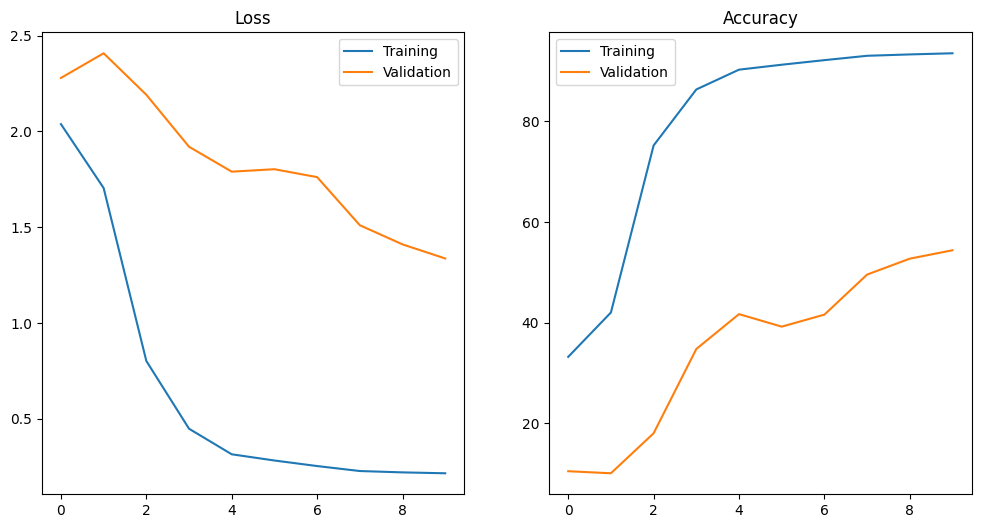

In [18]:
# Solution:
model = CNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss_function = torch.nn.CrossEntropyLoss()

# Record
train_losses = [] ; train_accs = []
val_losses = [] ; val_accs = []

# 10 epochs of training and validation
for epoch in range(10):

    print(f"Epoch: {epoch+1}")

    # Train 
    train_loss, train_acc = train(model, device, train_loader_sorted, optimizer, loss_function)

    # Validation
    val_loss, val_acc = validate(model, device, test_loader_sorted, loss_function)

    print('-'*30)

    train_losses.append(train_loss); train_accs.append(train_acc)
    val_losses.append(val_loss); val_accs.append(val_acc)

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(train_losses, label='Training')
plt.plot(val_losses, label="Validation")
plt.title("Loss")
plt.legend()
plt.subplot(122)
plt.plot(train_accs, label='Training')
plt.plot(val_accs, label="Validation")
plt.title("Accuracy")
plt.legend()

**A:** The effect depends on the exact model (and parameters) but the training accuracy should increase a bit more slowly than before and the validation accuracy should increase even more slowly. We only changed the order (and stochasticity) in which the samples are presented to the network during learning!

**Q:** To better understand what happened, modify the `validate()` method so that it returns a list of accuracies on each minibatch of the sorted test set, and plot these accuracies.

As the test set is also sorted, the first minibatches will only have zeros in them, the following only ones, and so on. If you want, you can figure out which digits are in a minibatch using the list `np.argsort(dataset_test.targets.numpy())` and the batch size.

In [19]:
# Solution:
def validate_per_minibatch(model, device, test_loader):

    # Evaluation mode, without the gradients
    model.eval()

    # Initialize metrics
    accuracies = [] 

    # Important! No backpropagation when testing.
    with torch.no_grad():

        # Iterate over the minibatches
        for data, target in test_loader:

            # Send the data to the device
            data, target = data.to(device), target.to(device)

            # Make the forward pass
            output = model(data)

            # Compute metrics
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct = pred.eq(target.view_as(pred)).sum().item() 

            # Record accuracies over the minibatches
            accuracies.append(100. * correct / data.size(0))
    

    return accuracies

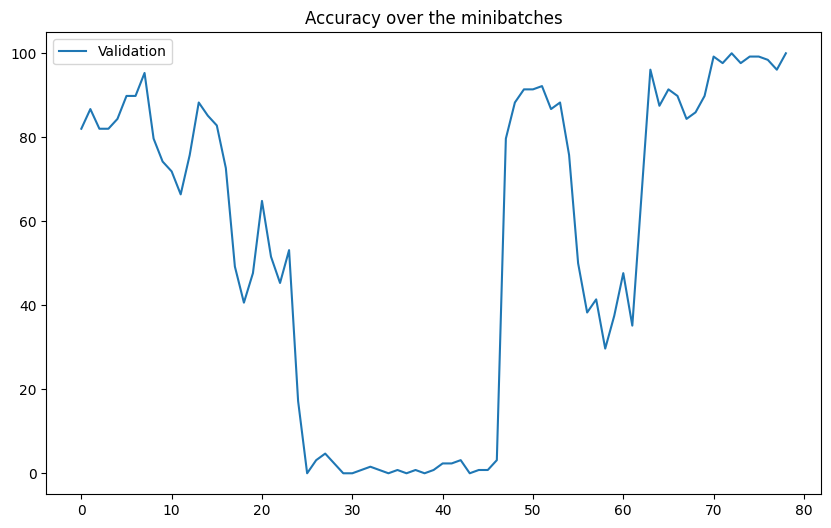

In [20]:
# Solution:
val_acc = validate_per_minibatch(model, device, test_loader_sorted)

plt.figure(figsize=(10, 6))
plt.plot(val_acc, label="Validation")
plt.title("Accuracy over the minibatches")
plt.legend()

**A:** We nicely observe **catastrophic forgetting**. The last digits seen during training were the 9s: they have a good test accuracy. The 8s were seen not too long ago, they are also OK. But the other digits have been completely forgotten! The older memories have been erased. This explains why you cannot train a deep network on-policy: the last episode would be remembered, but all the previous ones would be erased.

Depending on your learning rate, a notable exception is for the 6s, which look like 9s, and the 0s, which look like 8s: they share features with the digits which are still well recognized, so they perform OK.

**Optional Q:** Increase and decrease the learning rate of the optimizer. What do you observe? Is there a solution to this problem? 

**A:** Increasing the learning rate worsens the problem. Decreasing does help, but then learning is very slow. There is no solution to this problem for now, apart from taking **i.i.d** samples in each minibatch, which we can't if we act online.